In [230]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [231]:
# Prepare train and test data
train_dataset = MNIST(download=True, root='data', train=True, transform=ToTensor())
train_data = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = MNIST(download=True, root='data', train=False, transform=ToTensor())
test_data = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [235]:
# Make results reproducible
random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [236]:
def sigmoid(x, deriv=False):
  out = F.sigmoid(x)
  if deriv:
    return out * (1 - out)
  return out

def leaky_relu(x, deriv=False):
  factor = (x > 0) + 0.1
  if deriv:
    return factor
  return factor * x


def softmax(x, deriv=False):
  if deriv:
    # This is little unusual, but is required to calculate correct the correct partial derivate if e = x - u
    return torch.ones_like(x) 
  return x.exp() / x.exp().sum(dim=1, keepdim=True)

def onehot(x, n_classes):
  return torch.eye(n_classes)[x]

def get_weights_and_biases(in_features, out_features):
  W = torch.randn((out_features, in_features)) * 2/math.sqrt(in_features)
  b = torch.zeros(out_features)

  return W, b

In [237]:
# Define out layer sizes
in_features = 784
hidden1_features = 600
hidden2_features = 600
out_features = 10

# Define weights and biases
W1, b1 = get_weights_and_biases(in_features, hidden1_features)
W2, b2 = get_weights_and_biases(hidden1_features, hidden2_features)
W3, b3 = get_weights_and_biases(hidden2_features, out_features)

activation1 = leaky_relu
activation2 = leaky_relu
activation3 = softmax

# Prepare loss history
loss_history = []

In [238]:
# Baseline backprop model
class MLP(nn.Module):
  def __init__(self, in_features, hidden1_features, hidden2_features, out_features):
    super().__init__()
    self.l1 = nn.Linear(in_features, hidden1_features)
    self.l2 = nn.Linear(hidden1_features, hidden2_features)
    self.l3 = nn.Linear(hidden2_features, out_features)

    # Start with exactly the same weights.
    with torch.no_grad():
      self.l1.weight.copy_(W1)
      self.l1.bias.copy_(b1)
      self.l2.weight.copy_(W2)
      self.l2.bias.copy_(b2)
      self.l3.weight.copy_(W3)
      self.l3.bias.copy_(b3)

  def forward(self, x):
    x = activation1(self.l1(x))
    x = activation2(self.l2(x))
    x = self.l3(x)
    return x


model = MLP(in_features, hidden1_features, hidden2_features, out_features)

In [239]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_history = []
accuracy_history = []

In [240]:
step = 0
for epoch in range(5):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1

    optimizer.zero_grad()
    x0 = images.flatten(start_dim=1)

    pred = model(x0)
    loss = criterion(pred, labels)
    loss.backward()

    loss_history.append((step, loss.item()))

    tqdm_train_data.set_description(f"Loss: {loss.item()}")

    optimizer.step()

    if step % 100 == 0: 
      model.eval()
      tqdm_train_data.set_description(f"Testing")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        x3_pred = model(x0)
        pred_labels = x3_pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()

      accuracy = correct / tested
      accuracy_history.append((step, accuracy))
      model.train()
    

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/938 [00:00<?, ?it/s]

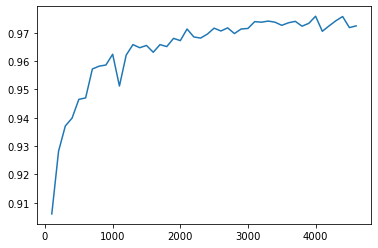

In [241]:
plt.plot(*zip(*accuracy_history))
plt.show()

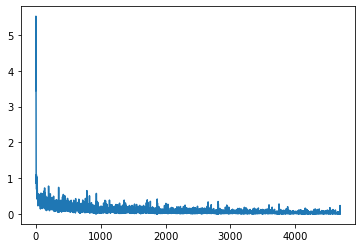

In [242]:
plt.plot(*zip(*loss_history))
plt.show()

In [244]:
# Save loss and accuracy history
torch.save(loss_history, "../results/backprop-loss_history.pt")
torch.save(accuracy_history, "../results/backprop-accuracy_history.pt")

In [197]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  x3_pred = model(x0)
  pred_labels = x3_pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 93.55999755859375%


In [173]:
logits = torch.tensor([[2.0, 5.0, 2.0, 2.0, 2.0], [2.0, 5.0, 2.0, 2.0, 2.0]])
pred = softmax(logits)
labels = torch.tensor([1, 2])

print(nn.CrossEntropyLoss()(logits, labels))
print(-(torch.log(pred) * torch.stack([onehot(label, pred.shape[1]) for label in labels])).sum(dim=1).mean())

tensor(1.6816)
tensor(1.6816)


In [ ]:
loss_history = []
accuracy_history = []

In [184]:
# Setup hyperparameters
ir = 1e-1 # Inference rate
lr = 1e-1 # Learning rate

# Should we just test the inference part
test = False

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

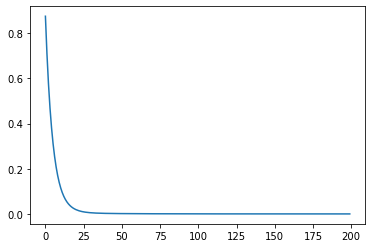

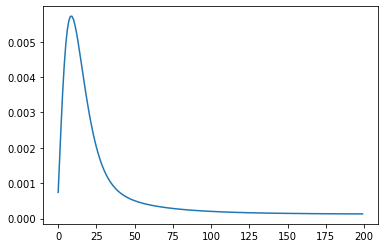

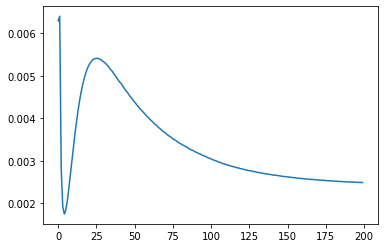

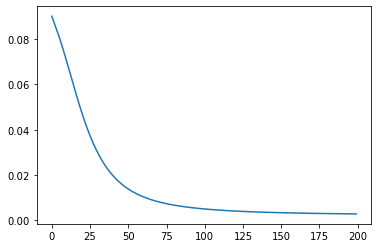

In [185]:
# Training loop
step = 0
for epoch in range(5):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1)
    batch_dim = x0.shape[0]
    x1 = torch.zeros((batch_dim, hidden1_features))
    v1 = torch.zeros((hidden1_features))

    x2 = torch.zeros((batch_dim, hidden2_features))
    v2 = torch.zeros((hidden2_features))

    x3 = torch.zeros((batch_dim, out_features))
    v3 = torch.zeros((out_features))

    x4 = onehot(labels, n_classes=10) # Constrain output to be the correct labels.

    x4_pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)

    loss = -(torch.log(x4_pred) * x4).sum(dim=1).mean()
    tqdm_train_data.set_description(f"Loss: {loss}")
    loss_history.append(loss)
    errors_history = []

    # Run predictive coding inference. 
    for t in range(200):
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2) @ W3.T + b3
      u4 = activation3(x3)

      # Calculate errors
      e1 = x1 - u1
      e2 = x2 - u2
      e3 = x3 - u3
      e4 = x4 - u4

      # Canculate derivatives
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      dx3 = -e3 + activation3(x3, deriv=True) * (e4)
      #dx4 = -e4 # Only do this during inference

      # Do actual steps
      x1 += ir * dx1
      x2 += ir * dx2
      x3 += ir * dx3
      #x4 -= ir * dx4 # Only do this during inference.

      if test:
        errors_history.append(((e1 ** 2).mean(), (e2 ** 2).mean(), (e3 ** 2).mean(), (e4 ** 2).mean()))

    error_histories = zip(*errors_history)
    for error_history in error_histories:
      plt.plot(error_history)
      plt.show()
      
    if test:
      break

    # Calculate gradients
    dW1 = e1[:, :, None] @ activation1(x0)[:, None, :]
    dW2 = e2[:, :, None] @ activation2(x1)[:, None, :]
    dW3 = e3[:, :, None] @ activation3(x2)[:, None, :]

    db1 = e1
    db2 = e2
    db3 = e3

    # Perform weight update here.
    W1 += lr * dW1.mean(dim=0)
    b1 += lr * db1.mean(dim=0)

    W2 += lr * dW2.mean(dim=0)
    b2 += lr * db2.mean(dim=0)

    W3 += lr * dW3.mean(dim=0)
    b3 += lr * db3.mean(dim=0)

    if step % 100 == 0:
      tqdm_train_data.set_description(f"Testing")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()

      accuracy = correct / tested
      accuracy_history.append((step, accuracy))

  if test:
    break

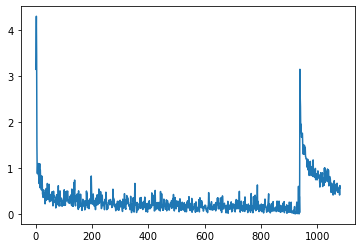

In [176]:
plt.plot(loss_history)
plt.show()

In [177]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  x3_pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)
  pred_labels = x3_pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 88.38999938964844%


Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 